In [6]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import time
import os
import random
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from torch import nn
from torchvision import transforms

from DatasetMedical import DatasetMedical
from Unet2D import Unet2D


def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, params_path, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc += acc * dataloader.batch_size
                running_loss += loss * dataloader.batch_size

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc,
                                                                                          torch.cuda.memory_allocated() / 1024 / 1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase == 'train' else valid_loss.append(epoch_loss)
        torch.save(model.state_dict(), params_path + f'{epoch}.pth')
    torch.save(model.state_dict(), params_path + 'final.pth')
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return train_loss, valid_loss


def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

def dice_metric(predb, yb):
    # Ventricle = 2, Background = 0
    segmented = 2 * predb.argmax(dim=1)

    # TP = 2 - 1 = 1, TN = 0 - 0 = 0, FP = 2 - 0 = 2, FN = 0 - 1 = -1
    conf = segmented - yb
    TP = (conf == 1).sum()
    TN = (conf == 0).sum()
    FP = (conf == 2).sum()
    FN = (conf == -1).sum()
    return 2 * TP / (2 * TP + FP + FN)

def batch_to_img(xb, idx):
    img = np.array(xb[idx, 0:3])
    return img.transpose((1, 2, 0))


def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

def get_random_folder_split(path):
    x_path = path / 'train_gray'
    gray_files = os.listdir(x_path)
    no_files = len(gray_files)
    indices = list(range(no_files))
    random.shuffle(indices)
    train_files = [gray_files[i] for i in indices[:int(np.floor(0.7*no_files))]]
    val_files = [gray_files[i] for i in indices[int(np.floor(0.7*no_files)): int(np.floor(0.85*no_files))]]
    test_files = [gray_files[i] for i in indices[int(np.floor(0.85*no_files)):]]
    return train_files, val_files, test_files

gd /work/datasets/medical_project/CAMUS_resized/train_gray
gd /work/datasets/medical_project/CAMUS_resized/train_gray
315
before gb torch.Size([1, 384, 384])


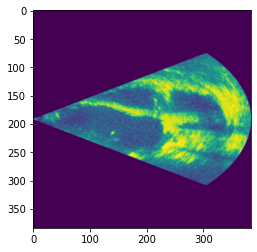

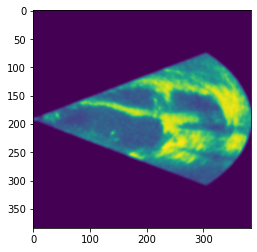

after gb torch.Size([1, 384, 384])
torch.Size([1, 384, 384]) torch.Size([384, 384])
Epoch 0/1
----------
before gb torch.Size([1, 384, 384])


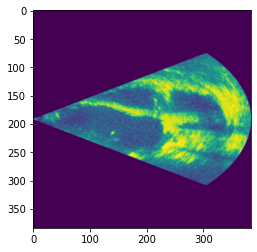

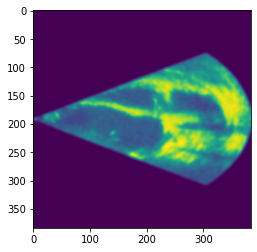

after gb torch.Size([1, 384, 384])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 1, 7, 7], but got 3-dimensional input of size [1, 384, 384] instead

In [7]:
def main():
    # enable if you want to see some plotting
    visual_debug = False
    params_path = 'models/model_epoch_'

    # batch size
    bs = 12

    # epochs
    epochs_val = 2

    # learning rate
    learn_rate = 0.01

    # sets the matplotlib display backend (most likely not needed)
    # mp.use('TkAgg', force=True)
    # Preprocessing
    # PREPROCESS SKAL GJØRES HER
    mean, std = 0.485, 0.229
    transform_train = transforms.Compose([
        transforms.RandomVerticalFlip(p=0.3),
    ])
    # Data Augmentation
    # LEGG TIL NYE METODER FOR AGUMENTATION HER

    # load the training data
    # CHANGE "trans" TO "preprocess" if applying preprocessing (gaussian blur and isotropic pixel size)
    base_path = Path('/work/datasets/medical_project/CAMUS_resized')
    train_files, val_files, _ = get_random_folder_split(base_path)
    train_dataset = DatasetMedical(base_path / 'train_gray', train_files,
                                    base_path / 'train_gt', transform_train, gaussian_blur=True)
    val_dataset = DatasetMedical(base_path / 'train_gray', val_files,
                                    base_path / 'train_gt', transform_train, gaussian_blur=True)
    print(len(train_dataset))
    # data = DatasetMedical(base_path / 'train_gray',
    #                      base_path / 'train_gt', transform=preprocess)
    # print(len(data))

    # split the training dataset and initialize the data loaders
    # train_dataset, valid_dataset, _ = torch.utils.data.random_split(
    #     data,
    #     (300, 100, 50),
    #     generator=torch.Generator().manual_seed(42)
    # )
    # Overskriver transformen her
    #train_dataset.dataset.transform = augmentation
    train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(val_dataset, batch_size=bs, shuffle=False)

    if visual_debug:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(train_dataset.open_as_array(150))
        ax[1].imshow(train_dataset.open_mask(150))
        plt.show()

    xb, yb = next(iter(train_dataset))
    print(xb.shape, yb.shape)

    # build the Unet2D with one channel as input and 2 channels as output
    unet = Unet2D(1, 2)

    # loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(unet.parameters(), lr=learn_rate)

    # do some training
    train_loss, valid_loss = train(unet, train_dataset, val_dataset, loss_fn, opt, acc_metric, epochs=epochs_val,
                                   params_path=params_path)

    # plot training and validation losses
    if visual_debug:
        plt.figure(figsize=(10, 8))
        plt.plot(train_loss, label='Train loss')
        plt.plot(valid_loss, label='Valid loss')
        plt.legend()
        plt.show()

    # predict on the next train batch (is this fair?)
    xb, yb = next(iter(train_dataset))
    with torch.no_grad():
        predb = unet(xb.cuda())

    # show the predicted segmentations
    if visual_debug:
        fig, ax = plt.subplots(bs, 3, figsize=(15, bs * 5))
        for i in range(bs):
            ax[i, 0].imshow(batch_to_img(xb, i))
            ax[i, 1].imshow(yb[i])
            ax[i, 2].imshow(predb_to_mask(predb, i))

        plt.show()
        
main()